# Without sWeights: `common_Dst_constr_B0toDstDsWithmu2Free_BDT-1.25`

# Plot the fit
    
I just want to recreate the figure of the fit with BDT > -1.25, with the colors I cherish.


## Import

In [1]:
import zfit
import json
import numpy as np
import timeit

from numpy.random import normal

from math import sqrt

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_saved_root, load_data, add_constr_Dst, json_to_latex_table, retrieve_params, format_previous_params
import plot.histogram as h
from plot.fit import plot_hist_fit_particle
from fit import define_zparams, sum_crystalball
from variables import name_params, name_params_KPiPi

Welcome to JupyROOT 6.22/02


In [2]:
name_params_KPiPi_print = {}
for key, value in name_params_KPiPi.items():
    name_params_KPiPi_print[key+'_Kpipi'] = name_params_KPiPi[key]

In [3]:
#name_data = 'common_Dst_constr'
#name_data_B0toDstDs = 'common_B0toDstDs_Dst_constr'

name_data = 'common_Dst_constrHEP'
name_data_B0toDstDs = 'common_B0toDstDs_Dst_constrHEP'

name_data_Dstto3pi = 'common_Dstto3piHEP' # same as sWeights as the unconstrained case

name_BDT = 'gradient_bkgHighB0M'

name_data_MC = 'MC_constr_opposedCB_sharedMean'
name_data_KPiPi = "data_KPiPi_constr"

BDT = -1.25

name_data_BDT = name_data + f'_BDT{BDT}'

## Load

### Json files

In [4]:
name_data_BDT = f"{name_data}_BDT{BDT}"
name_data_B0toDstDs_BDT = f"{name_data_B0toDstDs}_BDT{BDT}"

# Fixed alphaL, alphaR and nL
common_params = retrieve_params(name_data, name_folder=name_data)
# Fixed nR
MC_params = retrieve_params(name_data_MC, name_folder='MC')

# B0->DstKPiPi
Kpipi_params = retrieve_params(name_data_KPiPi, name_folder='data_KPiPi') # already in MeV 

# common with BDT cut (for startning values of the fit)
pipipi_params = format_previous_params(retrieve_params(name_data_BDT, name_folder=name_data), True)
# B0->DstDs with BDT cut (for the B0->DstDs PDF shape)
DstDs_params = format_previous_params(retrieve_params(name_data_B0toDstDs_BDT, name_folder=name_data_B0toDstDs), True) 

Load 
- `f_params_dict['1']` - the fixed parameters that will be changed in **mode 1**
- `f_params_dict['2']`  - the fixed parameters that will be changed in **mode 2**

In [5]:
f_params = {} # fixed parameters

for param in 'alphaL', 'alphaR', 'nL', 'r_bkgK':
    f_params[param] = common_params[param] # nominal value

f_params['nR'] = {}
f_params['nR']= MC_params['nR_MC']

for param in 'muL', 'muR', 'nL', 'nR', 'alphaR', 'alphaL', 'sigmaL', 'sigmaR', 'fraction':
    f_params[param+'_Kpipi'] = Kpipi_params[param]


In [6]:
df = load_saved_root('common_'+name_BDT, name_folder='common', vars=['B0_M', 'Dst_M', 'BDT'])
df = df.query(f"BDT > {BDT}")
df = add_constr_Dst(df)

/afs/cern.ch/user/c/correian/bd2dst3pi/output//root/common/common_gradient_bkgHighB0M.root


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/BDT_data_cut_-1.25


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='BDT', ylabel='Candidates / (0.06)'>)

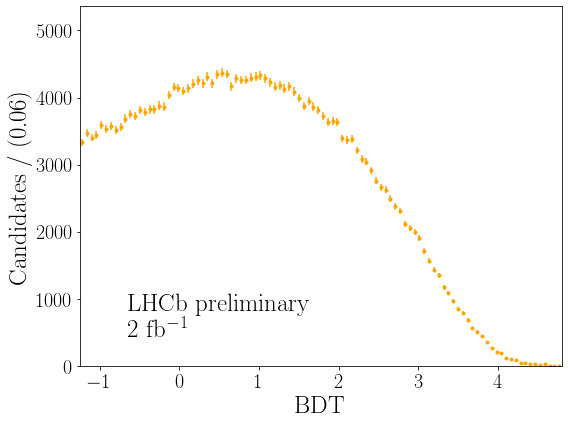

In [7]:
h.plot_hist_particle({'data\_cut\_-1.25': df},'BDT',
              n_bins = 100, mode_hist = False, colors=['orange', 'cyan'], pos_text_LHC=[0.1,0.2,'left'])

## Range of the variables

### Constrained $m(D^* 3\pi)$ of the `common` data

In [8]:
var = 'Dst_constr_B0_M'
low = 5150.
high = 5545.

## PLOT

### Values

In [9]:
initial_values = {
    # Signal        
    'mu'       :{ 'value': pipipi_params['mu']       , 'floating': True},
    'sigmaL'   :{ 'value': pipipi_params['sigmaL']   , 'floating': True},
    'sigmaR'   :{ 'value': pipipi_params['sigmaR']   , 'floating': True},
    'frac'     :{ 'value': pipipi_params['frac']     , 'floating': True},
    'n_sig'    :{ 'value': pipipi_params['n_sig']    , 'floating': True},
    # Combinatorial background        
    'lambda'   :{ 'value': pipipi_params['lambda']   , 'floating': True},
    'n_bkg'    :{ 'value': pipipi_params['n_bkg']    , 'floating': True},
    # Background decay D*Kpipi    
}

# Fixed parameters:
for param, value_param in f_params.items():
    initial_values[param] = {}
    initial_values[param]['value'] = value_param
    initial_values[param]['floating'] = False

# B0 -> D* Ds distribution
for vari in 'mu', 'sigma', 'n_sig' :
    initial_values[f'{vari}_Ds'] = {'value': DstDs_params[f'{vari}_B0Ds'], 'floating': False}

### Observables and variables

In [10]:
obs = zfit.Space("x", limits=(low, high))

zparams = define_zparams(initial_values, num=9)

mult = lambda r, n: r*n
zparams["n_bkgK"] = zfit.ComposedParameter(f"n_bkgK;9", mult, params=[zparams['r_bkgK'],zparams['n_sig']])    

### PDFs

In [11]:
model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                          zparams['sigmaL'], zparams['sigmaR'],
                                                          zparams['frac'], obs,                                                          
                                                          zparams['alphaL'], zparams['alphaR'], 
                                                          zparams['nL'], zparams['nR']
                                                         )


gaussian_B0Ds = zfit.pdf.Gauss(zparams['mu_Ds'],zparams['sigma_Ds'],obs=obs)

model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_Kpipi'], zparams['muR_Kpipi'], 
                                                          zparams['sigmaL_Kpipi'], zparams['sigmaR_Kpipi'],
                                                          zparams['fraction_Kpipi'], obs,
                                                          zparams['alphaL_Kpipi'], zparams['alphaR_Kpipi'], 
                                                          zparams['nL_Kpipi'], zparams['nR_Kpipi'])

exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)


model_S_ext = model_S.create_extended(zparams['n_sig'])
exp_ext = exponential.create_extended(zparams['n_bkg'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams['n_sig_Ds'])
model_K_ext = model_K.create_extended(zparams['n_bkgK'])

model = zfit.pdf.SumPDF([model_S_ext, gaussian_B0Ds_ext, model_K_ext, exp_ext]) # gauss is folded by frac

### Plotting

Number of d.o.f. in the model:  7
Reduced chi2:  1.5362764269907183
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_Dst_constrHEP_BDT-1.25/Dst_constr_B0_M_common_Dst_constrHEP_BDT-1.25_details_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($B^0|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>,
 <AxesSubplot:xlabel='(reduced $\\chi^2$=1.54)', ylabel='residuals / $\\sigma$'>)

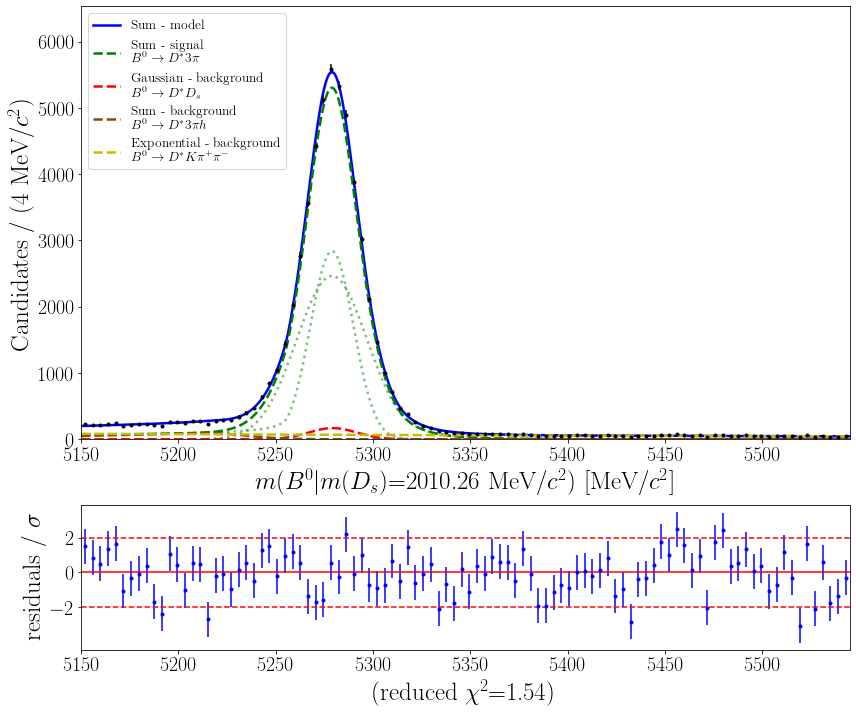

In [27]:
name_data_plot = name_data_BDT + '_details'
plot_hist_fit_particle(df, var, models = [model,[model_S_ext, crystalBallL_S, crystalBallR_S], gaussian_B0Ds_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$','\n $B^0\\to D^*3\pi h$',
                                      '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data_BDT,
                       colors=['b','g','r','saddlebrown','y'],
                       fontsize_leg=13.5, show_chi2=True,
                       colWidths=[0.06,0.01,0.05,0.06], 
                      )

Number of d.o.f. in the model:  7
Reduced chi2:  1.5362764269907183
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_Dst_constrHEP_BDT-1.25/Dst_constr_B0_M_common_Dst_constrHEP_BDT-1.25_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($B^0|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>,
 <AxesSubplot:ylabel='residuals / $\\sigma$'>)

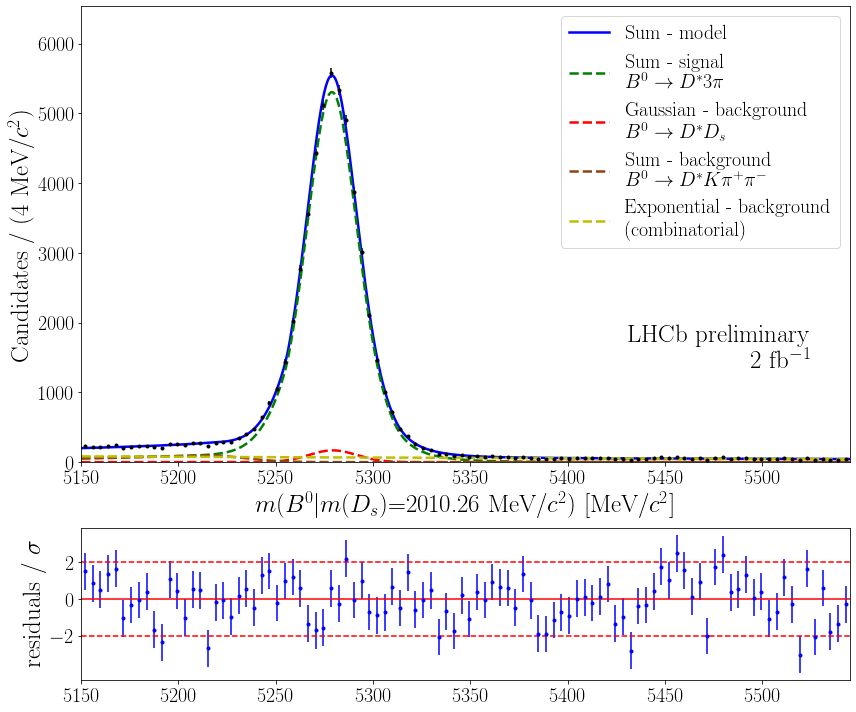

In [30]:
name_data_plot = name_data_BDT
plot_hist_fit_particle(df,var, models = [model,model_S_ext, gaussian_B0Ds_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$',
                                      '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data_BDT,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=20., pos_text_LHC=[0.95, 0.30, 'right'],
                      )

Number of d.o.f. in the model:  7
Reduced chi2:  1.5362764269907183
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_Dst_constrHEP_BDT-1.25/Dst_constr_B0_M_common_Dst_constrHEP_BDT-1.25_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($B^0|m(D_s)$=2010.26 MeV/$c^2$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>,
 <AxesSubplot:ylabel='residuals / $\\sigma$'>)

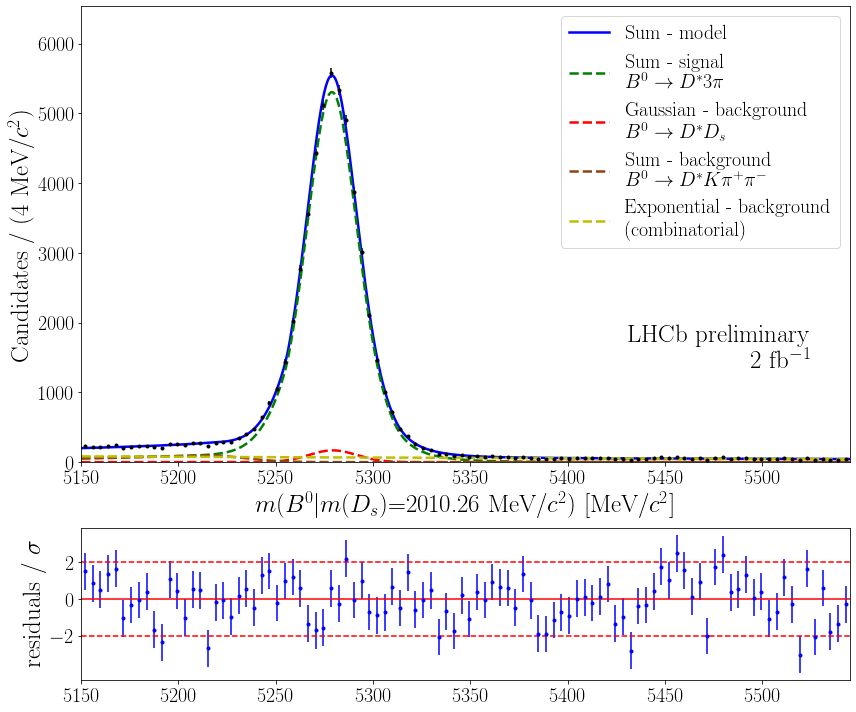

In [31]:
name_data_plot = name_data_BDT
plot_hist_fit_particle(df,var, models = [model,model_S_ext, gaussian_B0Ds_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$',
                                      '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data_BDT,
                       colors=['b','g','r','saddlebrown','y'], loc_leg='best',
                       fontsize_leg=20., pos_text_LHC=[0.95, 0.30, 'right'],
                      )

### Params

In [15]:
fitted_params = retrieve_params(name_data_BDT, name_folder=name_data)

In [16]:
fitted_params

{'frac|BDT-1.25': 0.4348224739242823,
 'frac|BDT-1.25_err': 0.0214166563625303,
 'lambda|BDT-1.25': -0.0015668628592356015,
 'lambda|BDT-1.25_err': 0.0002367110123071513,
 'mu|BDT-1.25': 5278.875385598795,
 'mu|BDT-1.25_err': 0.07851332349318772,
 'n_B': 1572.5494066211236,
 'n_B_err': 48.37274181639924,
 'n_bkg|BDT-1.25': 6193.831921375621,
 'n_bkg|BDT-1.25_err': 190.52668941616346,
 'n_sig|BDT-1.25': 51358.013306884655,
 'n_sig|BDT-1.25_err': 281.29155447457447,
 'sigmaL|BDT-1.25': 11.004237612070206,
 'sigmaL|BDT-1.25_err': 0.2207932182568078,
 'sigmaR|BDT-1.25': 18.210413383063955,
 'sigmaR|BDT-1.25_err': 0.2389062282730971}

In [17]:
json_to_latex_table(name_data_BDT, name_data, name_params)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/tables/common_Dst_constrHEP/common_Dst_constrHEP_BDT-1.25_params.tex
\begin{tabular}[t]{lc}
\hline
Variable &Fitted Value\\
\hline\hline
$f_{\frac{L}{R}}$&$0.435\pm0.021$\\
\hline
$\lambda_{B,c}$&$-0.00157\pm0.00024$\\
\hline
$\mu_S$&$5278.875\pm0.079$\\
\hline
B&$1573\pm48$\\
\hline
$n_{B,c}$&$(6.19\pm0.19)\times 10^3$\\
\hline
$n_S$&$(5.136\pm0.028)\times 10^4$\\
\hline
$\sigma_{L, S}$&$11.00\pm0.22$\\
\hline
$\sigma_{R, S}$&$18.21\pm0.24$\\
\hline
\end{tabular}
